In [1]:
import torch.nn as nn
import torch as t
from typing import Tuple

from torch.nn import Conv2d, Flatten, Linear, ConvTranspose2d, ReLU, Unflatten

class VAE(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder_base = nn.Sequential(
            Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            Flatten(),
            Linear(32*7*7, 100),
        )

        self.encoder_mu = nn.Linear(100,5)
        self.encoder_sigma = nn.Linear(100,5) # outputs log(sigma)

        self.decoder = nn.Sequential(
            Linear(5, 100),
            Linear(100, 32*7*7),
            nn.ReLU(),
            Unflatten(1, (32, 7, 7)),
            ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1)
        )
    def forward(self, x: t.Tensor) -> Tuple[t.Tensor, t.Tensor, t.Tensor]:
        '''
        Returns a tuple of (mu, logsigma, z), where:
            mu and logsigma are the outputs of your encoder module
            z is the sampled latent vector taken from distribution N(mu, sigma**2)
        '''
        x = self.encoder_base(x)
        mu = self.encoder_mu(x)
        logsigma = self.encoder_sigma(x)
        z = mu + t.exp(logsigma) * t.randn_like(mu)
        output = self.decoder(z)
        return mu, logsigma, output

/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <D9493EF5-8DAB-3A5D-85D5-684F04544B84> /Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <52337463-FA04-3610-8715-68C586545714> /Users/josephbloom/miniforge3/envs/arena/lib/python3.10/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


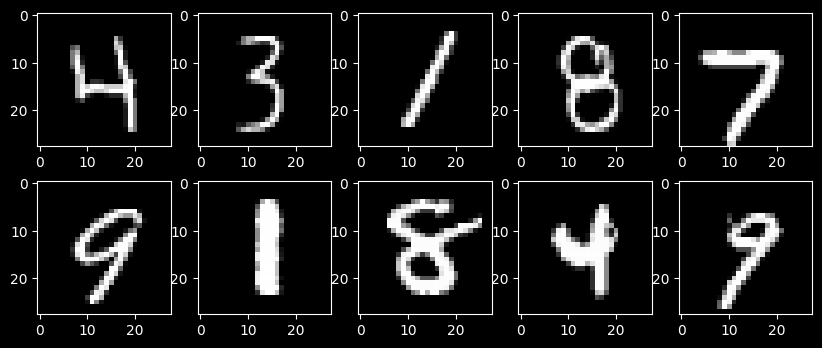

In [2]:
# load l2 loss
criterion = nn.MSELoss()

# load mnist data with torch vision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_data = MNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='data', train=False, download=True, transform=ToTensor())

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# visualize data
import matplotlib.pyplot as plt
import numpy as np

def show_images(images: t.Tensor):
    images = images.reshape(-1, 28, 28)
    images = images.detach().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
    plt.show()

images, labels = next(iter(train_loader))
show_images(images)

In [3]:
oy_vae = VAE()

# load optimizer
optimizer = t.optim.Adam(oy_vae.parameters(), lr=1e-3)
loss_fn_1 = nn.MSELoss()

def loss_fn(recon_x, x, mu, logvar):
    MSE = loss_fn_1(recon_x, x)
    KLD = -0.5 * t.sum(0.5*(mu.pow(2) + logvar.exp().exp(2) - 1) - logvar)
    return MSE + KLD

